In [3]:
# Load and inspect the data
library(tidyverse)
library(tidymodels)

players <- read_csv("https://raw.githubusercontent.com/achan919/dsci-final-project/refs/heads/main/players.csv")

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


# Title

#### Does a player’s gender and play time correlate to a player’s experience level?

# Introduction
A research group is collecting data about how people play video games. They have set up a MineCraft server, and players’ actions are recorded as they navigate through the world. For running this project, they need to target their recruitment efforts, and make sure they have enough resources to handle the number of players they attract. The purpose of our project is to provide an idea for this and use data analysis to prove whether this idea can effectively assist their recruitment.

Understanding how different player characteristics relate to gameplay experience is essential for designing engaging game environments and tailoring content to different player groups. In behavioral game analytics, experience level is often used as a proxy for proficiency, engagement, or familiarity with game mechanics. Identifying factors that correlate with experience level can help inform game balancing, player retention strategies, and the design of personalized player experiences.

In this project, we analyze player information and gameplay behaviour using two data sources: a player dataset containing demographic variables and a session dataset containing gameplay durations. Our research question is:

**Does a player’s gender and play time relate to their experience level?**

To answer this question, we examine whether a player’s gender and average play time are related to their experience level. By summarizing and visualizing these variables, we aim to identify patterns in how play time and gender differ across experience groups.

# Data Description
The file `players.csv` was collected by a research group in Computer Science at UBC to help us complete our project. It contains 196 players’ information and 7 variables columns:

| Variable     |Data Type | Description |
|--------------|----------|-------------|
| experience   | chr |Level of experience (Pro, Veteran, Amateur, Regular, Beginner) |
| subscribe    | lgl |Whether the player subscribed to the newsletter |
| hashedEmail  | chr | Hashed/hidden email of the player |
| played_hours | dbl |Total hours played (mean = 5.846) |
| name         | chr |Player's first name |
| gender       | chr |Gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other) |
| Age          | dbl |Player age in years (mean = 21.14) |

# Methods & Results

### **1. Wrangling + Cleaning**

The players table contains demographic and experience-related attributes describing each user. Variables such as experience and gender are categorical. To ensure proper treatment in grouping, plotting, or modeling, these fields were converted into factor types using **as_factor()**.

In [57]:
#Tidy players data
players_tidy <- players |>
  mutate(
    experience = as_factor(experience),
    gender = as_factor(gender)
  )
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


For the player data set, we also need to compute the mean of each numeric variable. This helps identify and compare the overall trends in player attributes such as age and playtime and give us a sense of what the data looks like before doing more analysis.

In [59]:
#Calculate players mean
player_means <- players_tidy |>
  summarize(across(where(is.numeric), mean, na.rm = TRUE)) |>
  pivot_longer(cols = everything(),
               names_to = "Variable",
               values_to = "Mean")
player_means

Variable,Mean
<chr>,<dbl>
played_hours,5.845918
Age,21.139175


### **2. Exploratory Data Analysis**

In [60]:
# Gender distribution
players_tidy |>
  count(gender)

# Experience distribution
players_tidy |>
  count(experience)

# Summary of avaerage play time (hours) by experience group
avg_play_time_experience <- players_tidy |>
  group_by(experience) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE))
avg_play_time_experience

# Summary of average play time (hours) by gender
avg_play_time_gender <- players_tidy |>
  group_by(gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE))
avg_play_time_gender

# Summary of average play time (hours) by gender and experience
avg_play_time_combined <- players_tidy |>
  group_by(experience, gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE)) |>
  arrange(experience, gender)
avg_play_time_combined

gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,6
Other,1


experience,n
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


experience,avg_play_time
<fct>,<dbl>
Pro,2.6000000
Veteran,0.6479167
Amateur,6.0174603
Regular,18.2083333
Beginner,1.2485714


gender,avg_play_time
<fct>,<dbl>
Male,4.12741935
Female,10.63513514
Non-binary,14.88000000
Prefer not to say,0.37272727
Agender,6.25000000
Two-Spirited,0.08333333
Other,0.20000000


`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,gender,avg_play_time
<fct>,<fct>,<dbl>
Pro,Male,3.2909091
Pro,Non-binary,0.0000000
Pro,Other,0.2000000
Veteran,Male,0.2870968
Veteran,Female,0.8800000
Veteran,Non-binary,0.4875000
Veteran,Prefer not to say,0.7000000
Veteran,Agender,6.2500000
Amateur,Male,4.3300000


### **3. Visualizations**

#### Visualization 1: Gender Distribution 

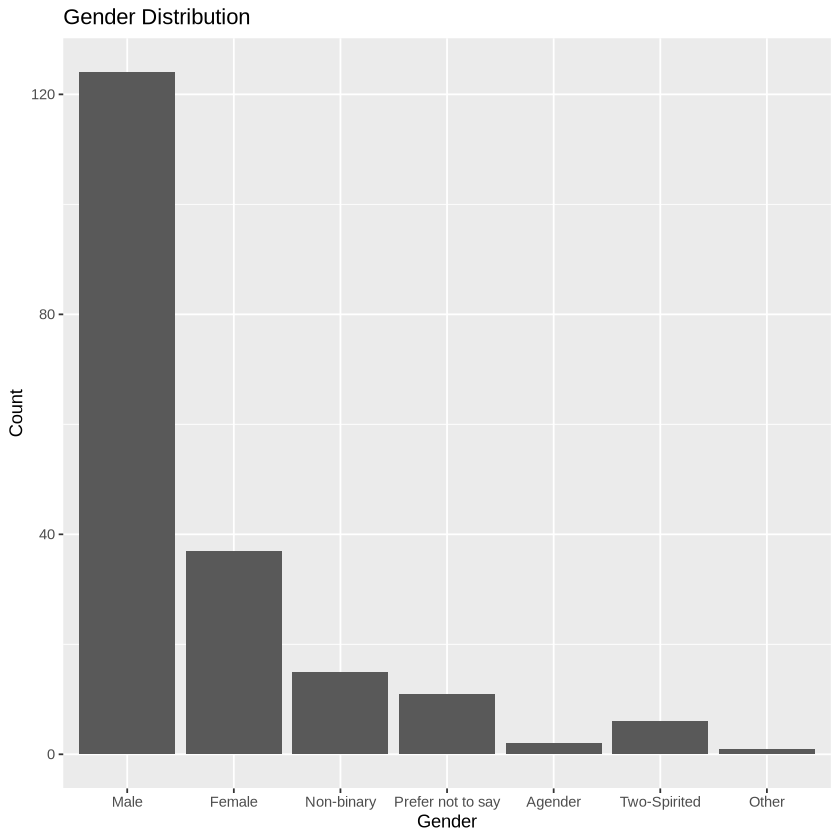

In [61]:
# shows the count for each gender
gender_distribution_plot <- players_tidy |>
  ggplot(aes(x = gender)) +
  geom_bar() +
  labs(title = "Gender Distribution",
       x = "Gender",
       y = "Count")
gender_distribution_plot

 #### Visualization 2: Experience Distribution

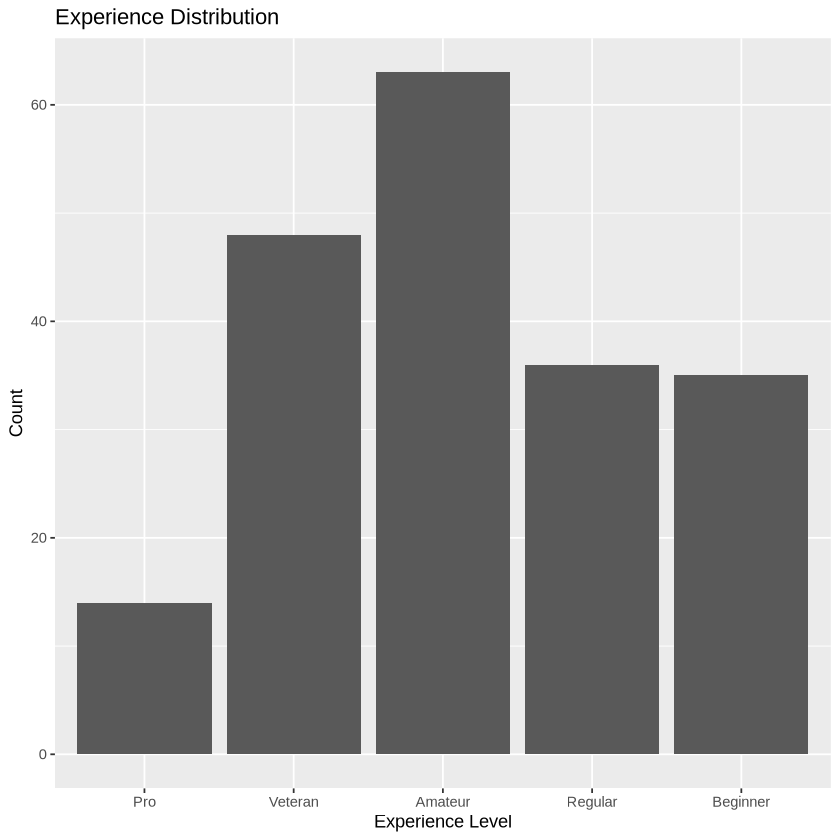

In [62]:
# shows the composition of player experience
experience_distribution_plot <- players_tidy |>
  ggplot(aes(x = experience)) +
  geom_bar() +
  labs(title = "Experience Distribution",
       x = "Experience Level",
       y = "Count")
experience_distribution_plot

#### Visualization 3: Average Play Time By Experience

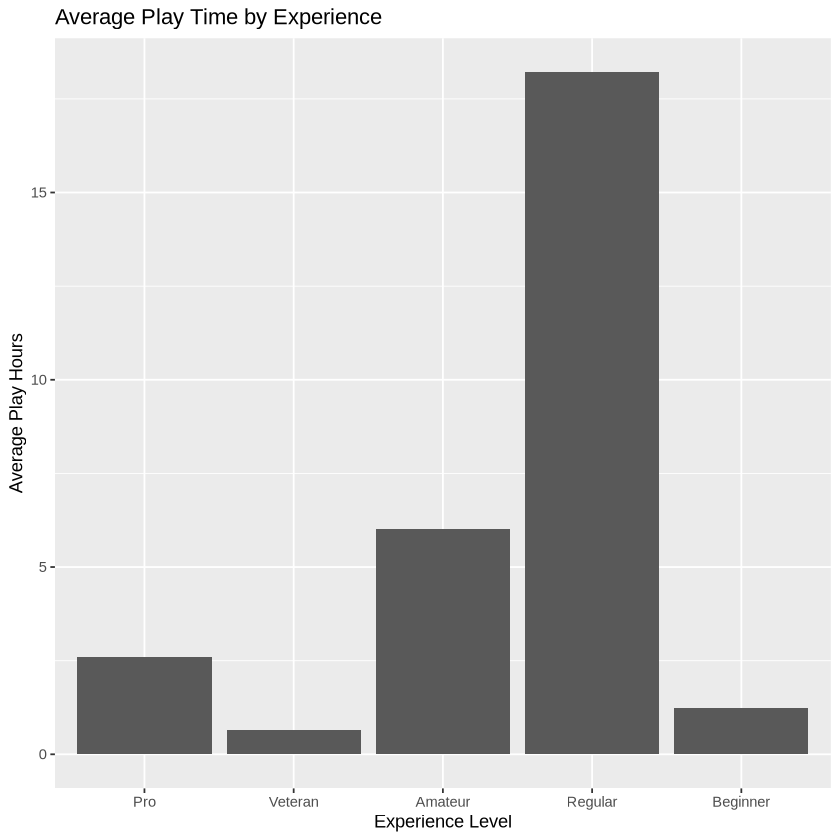

In [70]:
playtime_experience_plot <- ggplot(avg_play_time_experience, aes(x = experience, y = avg_play_time)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Experience",
       x = "Experience Level",
       y = "Average Play Hours")
playtime_experience_plot

#### Visualization 4: Average Play Time By Gender

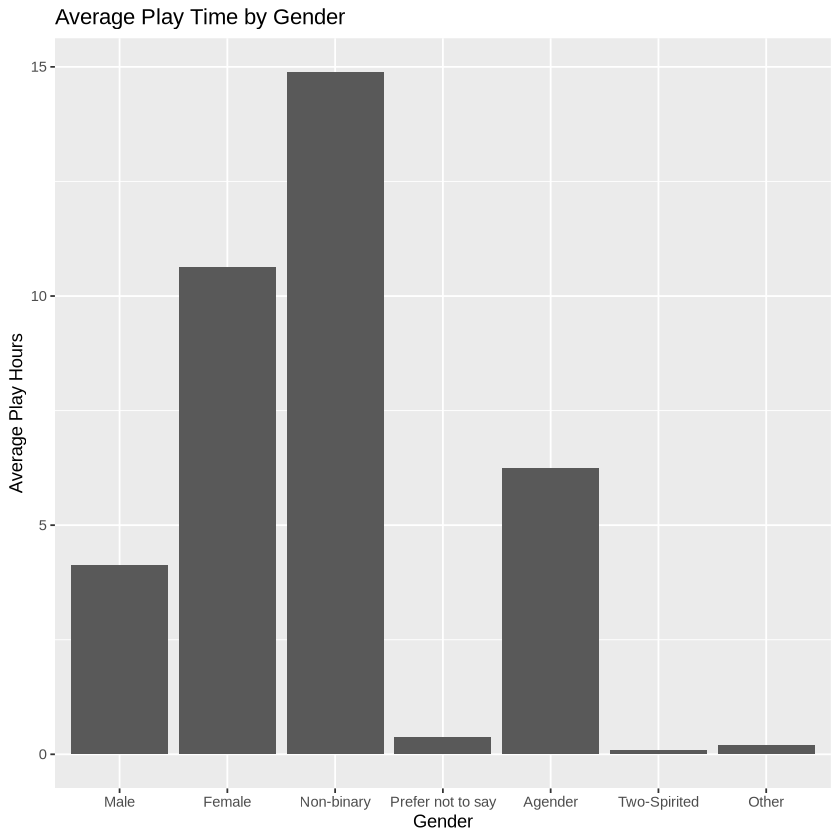

In [73]:
playtime_gender_plot <- ggplot(avg_play_time_gender, aes(x = gender, y = avg_play_time)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Play Time by Gender",
       x = "Gender",
       y = "Average Play Hours")
playtime_gender_plot

#### Visualization 5: Average Play Time by Experience and Gender

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


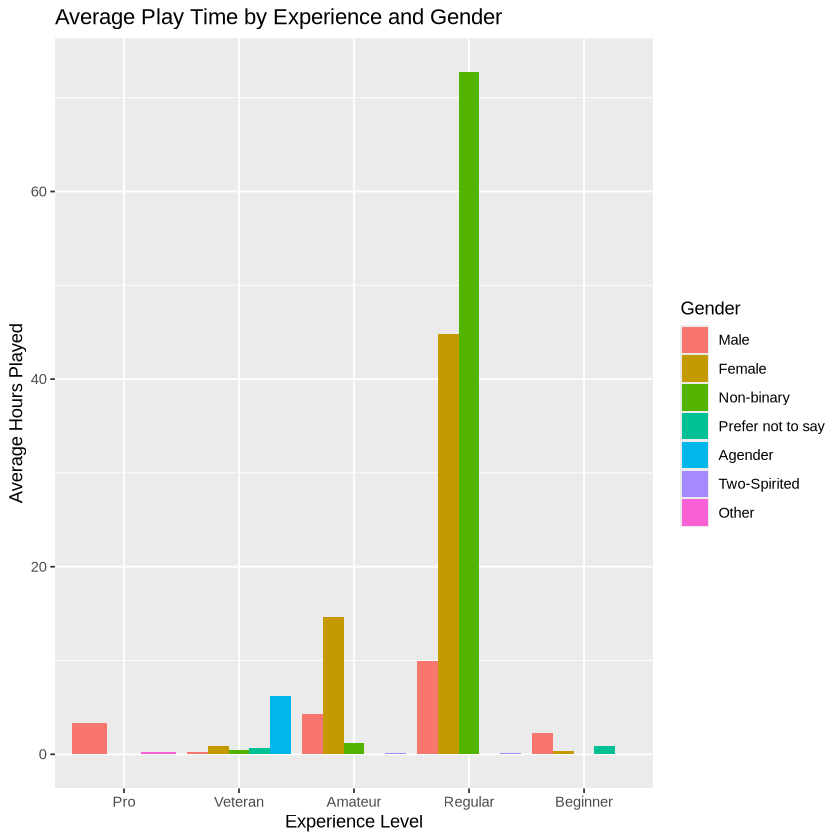

In [74]:
experience_gender_plot <- players_tidy |>
  group_by(experience, gender) |>
  summarise(avg_play_time = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = experience, y = avg_play_time, fill = gender)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = "Average Play Time by Experience and Gender",
    x = "Experience Level",
    y = "Average Hours Played",
    fill = "Gender"
  )
experience_gender_plot 

# Discussion

Our analysis examined whether a player’s gender and total play time relate to their experience level. From the summary statistics and visualizations, we can see several patterns: 


First, the boxplot comparing total play time across experience levels (Figure 1) suggests that more experienced players tend to accumulate greater total play time. This pattern aligns with the expectation that experience is built over longer engagement with the game.


Second, gender distributions (Figure 2) indicate that genders may not be evenly represented across experience levels. While this does not establish causation, it highlights demographic differences that may contribute to differences in experience development.


Third, combining gender and experience (Figure 3) shows that the effect of gender on play time may differ across experience groups.


Overall, our findings align with behavioral expectations: **higher experience levels are generally associated with greater accumulated play time. Gender appears to influence participation patterns, although more detailed modeling would be required to investigate this relationship more precisely.**

# References